# Preprocessing ERASMUS Glioma Dataset
Now, let's do this one last time!

The goal of this file is to create tfrecord files of the ERASMUS Glioma dataset, that can be used for training. The result should be tfrecord files for each leasion with a label indication what kind of tumor is visible in the leasion.

Citation: Sebastian R. van der Voort, Fatih Incekara, Maarten M.J. Wijnenga, Georgios Kapsas, Renske Gahrmann, Joost W. Schouten, Hendrikus J. Dubbink, Arnaud J.P.E. Vincent, Martin J. van den Bent, Pim J. French, Stefan Klein, Marion Smits,
The Erasmus Glioma Database (EGD): Structural MRI scans, WHO 2016 subtypes, and segmentations of 774 patients with glioma,
Data in Brief,
Volume 37,
2021,
107191,
ISSN 2352-3409,
https://doi.org/10.1016/j.dib.2021.107191.
(https://www.sciencedirect.com/science/article/pii/S2352340921004753)

Infos about the dataset:
- the dataset contains images of different gliomas
- age and sex are included, as well as the IDH, 1p19q status and grade for each tumor, we will most likely use these last values to get the proper grading for each patient
- all the other information we'll ignore

The dataset structure looks like this:
```
path_to_egd_dataset_folder
│
│__MR_EGD-0001
    │
    │__1_T1
        │
        │__NIFTI
            │
            │__T1.nii.gz
    │__2_T1GD
        │
        │__NIFTI
            │
            │__T1GD.nii.gz
    │__3_T2
        │
        │__NIFTI
            │
            │__T2.nii.gz
    │__4_FLAIR
        │
        │__NIFTI
            │
            │__FLAIR.nii.gz
    │__5_MASK
        │
        │__NIFTI
            │
            │__MASK.nii.gz
│__MR_EGD-0002
│__MR_EGD-0003
...
```

In [1]:
# TO-DO:
# [ ] Get overview of dataset
# [ ] Rotate images 90 degress and percentile normalize them
# [ ] Create png images of the largest visible tumor slice in each scan
# [ ] Combine the four sequences and the segmentation mask into a single tfrecord file
# [ ] Profit?

Let's import all the libraries we'll need for the data preparation

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from pathlib import Path
import random
import nibabel as nib

Then we'll define the paths we'll be using in this notebook

In [3]:
path_to_egd_dataset_folder = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EDG_manual')
path_to_egd_genetic_data = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/egd_dataset_infos/resources/PROJECT_DATA/files/Genetic_and_Histological_labels.xlsx')
path_to_egd_png_slices = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UCSF-PDGM/UCSF-PDGM_slices')
path_to_egd_tfrs = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UCSF-PDGM/UCSF-PDGM_tfrs')

path_to_ucsf_pdgm_rgb_tfrs = path_to_egd_tfrs / 'rgb_tfrs'
path_to_ucsf_pdgm_gray_tfrs = path_to_egd_tfrs / 'gray_tfrs'

IMG_SIZE = 240

In [19]:
# create custom class for each patient to store all relevant information

class Patient:
    def __init__(self, id):
        self.id = id

        self.t1 = None # Path to T1 image
        self.t1c = None # Path to T1c image
        self.t2 = None # Path to T2 image
        self.flair = None # Path to FLAIR image

        self.tumor_segmentation = None # Path to tumor segmentation mask

        self.classification = None # Number between 0 and 4 (for further information see below)

## Clean up dataset IDs
First let's get an overview over the dataset

In [10]:
egd_genetic_data = pd.read_excel(path_to_egd_genetic_data)
print("Number of patients: ", len(egd_genetic_data))
print(egd_genetic_data.value_counts('IDH'))
print(egd_genetic_data.value_counts('1p19q'))
print(egd_genetic_data.value_counts('Grade'))
egd_genetic_data.head()

Number of patients:  774
IDH
 0    312
-1    307
 1    155
Name: count, dtype: int64
1p19q
-1    515
 0    186
 1     73
Name: count, dtype: int64
Grade
 4    502
 2    135
 3     79
-1     58
Name: count, dtype: int64


,Subject,IDH,1p19q,Grade
0,EGD-0001,-1,-1,4
1,EGD-0002,-1,-1,2
2,EGD-0003,-1,-1,4
3,EGD-0004,1,1,2
4,EGD-0005,-1,-1,4


In [ ]:
# we need to drop all patients where there's no information about the IDH, 1p19q status or grade
# meaning: we drop all the patients where the columns are -1
egd_genetic_data = egd_genetic_data[egd_genetic_data['IDH'] != -1]
egd_genetic_data = egd_genetic_data[egd_genetic_data['1p19q'] != -1]
egd_genetic_data = egd_genetic_data[egd_genetic_data['Grade'] != -1]
print(egd_genetic_data.value_counts('IDH'))
print(egd_genetic_data.value_counts('1p19q'))
print(egd_genetic_data.value_counts('Grade'))
print("New number of patients: ", len(egd_genetic_data))

IDH
1    136
0     86
Name: count, dtype: int64
1p19q
0    153
1     69
Name: count, dtype: int64
Grade
2    127
4     67
3     28
Name: count, dtype: int64
New number of patients:  222


### Converting WHO Glioma Classification 2016 to 2021
Our mapping logic goes like this:\
If IDH = mutant:\
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If 1q19q = codeleted -> Oligodendroglioma, IDH-mutant, 1p19q-codeleted\
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Else -> Astrocytome, IDH-mutant\
If IDH = wildtype:\
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If grade = 4 -> Glioblastoma, IDH-wildtype\
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Else grade = 2 or 3 -> Astrocytome, IDH-wildytpe

For the IDH mutation status and the 1p/19q co-deletion status patients have either label 1 (when the tumor was IDH mutated or 1p/19q co-deleted, respectively) or label 0 (when the tumor was IDH wildtype or 1p/19q intact, respectively)

The labels for the pretraining dataset are going to be:
- 0: Glioblastoma, IDH-wildtype
- 1: Astrocytoma, IDH-wildtype
- 2: Astrocytoma, IDH-mutant
- 3: Oligodendroglioma, IDH-mutant, 1p/19q-codeleted
- 4: brain metastases\
(there are no brain metastases in this dataset, so we can forget about those)

In [14]:
# iterate over each patient in the dataset and add a new column depending on the values of IDH, 1p19q and Grade

def assign_new_classification(row):
    if row["IDH"] == 1:
        if row["1p19q"] == 1:
            return 3 # Oligodendroglioma, IDH-mutant and 1p19q-codeleted
        elif row["1p19q"] == 0:
            return 2 # Astrocytoma, IDH-mutant
    elif row["IDH"] == 0:
        if row["Grade"] == 4:
            return 0 # Glioblastoma, IDH-wildtype
        elif (row["Grade"] == 2 or row["Grade"] == 3):
            return 1
    else:
        return -1

egd_genetic_data['classification'] = egd_genetic_data.apply(assign_new_classification, axis=1)

In [16]:
print(egd_genetic_data.value_counts('classification'))
egd_genetic_data.head()

classification
3    69
2    67
0    66
1    20
Name: count, dtype: int64


,Subject,IDH,1p19q,Grade,classification
3,EGD-0004,1,1,2,3
7,EGD-0008,1,1,2,3
8,EGD-0009,0,0,2,1
10,EGD-0011,1,1,2,3
13,EGD-0014,0,0,4,0


Isolate the patient IDs and their pathologies

In [18]:
# convert IDs and classes to dictionary for easy access
patients_ids_and_classes = egd_genetic_data.set_index("Subject")["classification"].to_dict()
print(patients_ids_and_classes)


{'EGD-0004': 3, 'EGD-0008': 3, 'EGD-0009': 1, 'EGD-0011': 3, 'EGD-0014': 0, 'EGD-0020': 3, 'EGD-0022': 3, 'EGD-0024': 2, 'EGD-0029': 2, 'EGD-0033': 3, 'EGD-0041': 1, 'EGD-0055': 0, 'EGD-0057': 3, 'EGD-0066': 3, 'EGD-0068': 3, 'EGD-0072': 2, 'EGD-0073': 0, 'EGD-0074': 2, 'EGD-0075': 0, 'EGD-0078': 3, 'EGD-0080': 0, 'EGD-0085': 0, 'EGD-0086': 2, 'EGD-0090': 2, 'EGD-0099': 1, 'EGD-0101': 2, 'EGD-0106': 2, 'EGD-0107': 2, 'EGD-0115': 0, 'EGD-0118': 2, 'EGD-0122': 2, 'EGD-0123': 3, 'EGD-0128': 2, 'EGD-0133': 3, 'EGD-0137': 3, 'EGD-0143': 3, 'EGD-0144': 0, 'EGD-0145': 2, 'EGD-0146': 3, 'EGD-0160': 2, 'EGD-0161': 1, 'EGD-0162': 3, 'EGD-0165': 0, 'EGD-0176': 0, 'EGD-0177': 3, 'EGD-0179': 3, 'EGD-0183': 0, 'EGD-0185': 2, 'EGD-0186': 3, 'EGD-0187': 3, 'EGD-0188': 2, 'EGD-0192': 0, 'EGD-0193': 0, 'EGD-0194': 3, 'EGD-0196': 0, 'EGD-0197': 0, 'EGD-0198': 0, 'EGD-0199': 3, 'EGD-0202': 0, 'EGD-0203': 2, 'EGD-0208': 2, 'EGD-0211': 2, 'EGD-0214': 3, 'EGD-0217': 3, 'EGD-0221': 3, 'EGD-0226': 0, 'EGD-0228

## Get Nifti and Segmentation Files for the IDs

In [20]:
all_patients = []
patients_with_missing_data = []

# loop through ids and create patient objects
for id in tqdm(patients_ids_and_classes.keys()):
    patient = Patient(id)

    path_patient_name = "MR_" + str(id)
    path_to_t1 = path_to_egd_dataset_folder / path_patient_name / "1_T1" / "NIFTI" / "T1.nii.gz"
    path_to_t1c = path_to_egd_dataset_folder / path_patient_name / "2_T1GD" / "NIFTI" / "T1GD.nii.gz"
    path_to_t2 = path_to_egd_dataset_folder / path_patient_name / "3_T2" / "NIFTI" / "T2.nii.gz"
    path_to_flair = path_to_egd_dataset_folder / path_patient_name / "4_FLAIR" / "NIFTI" / "FLAIR.nii.gz"
    path_to_segmentation = path_to_egd_dataset_folder / path_patient_name / "5_MASK" / "NIFTI" / "MASK.nii.gz"

    paths_to_files = [path_to_t1, path_to_t1c, path_to_t2, path_to_flair, path_to_segmentation]

    for path in paths_to_files:
        if not path.is_file():
            patients_with_missing_data.append(id)
            print(f"{path} for patient {id} does not exist")
            continue

    patient.t1 = path_to_t1
    patient.t1c = path_to_t1c
    patient.t2 = path_to_t2
    patient.flair = path_to_flair
    patient.tumor_segmentation = path_to_segmentation

    patient.classification = patients_ids_and_classes[id]

    all_patients.append(patient)

100%|██████████| 222/222 [00:00<00:00, 3757.05it/s]


In [21]:
print(f"# of all patients: {len(all_patients)}")

# of all patients: 222


Display 9 random images from all patients including the segmentations

In [22]:
def visualize_random_patients(all_patients):

    # Funktion zum Laden und Anzeigen eines NIfTI-Bildes
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    # 9 zufällige Patienten auswählen
    random_patients = random.sample(all_patients, 9)

    # 3x3 Grafik erstellen
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        
        # Zufällige MRT Sequenz auswählen
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        
        # MRT Bild laden
        image = load_nifti_image(sequence_path)
        
        # Segmentierung laden
        segmentation = load_nifti_image(patient.tumor_segmentation)
        
        # Größte sichtbare Tumorschicht finden
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # MRT Bild anzeigen
        ax.imshow(image[:, :, slice_index], cmap = 'gray')
        
        # Segmentierung farblich darüber legen
        ax.imshow(segmentation[:, :, slice_index], cmap='Reds', alpha=0.5)
        
        ax.axis('off')

        # Title
        max_value = np.max(image)
        mean_value = np.mean(image)
        min_value = np.min(image)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

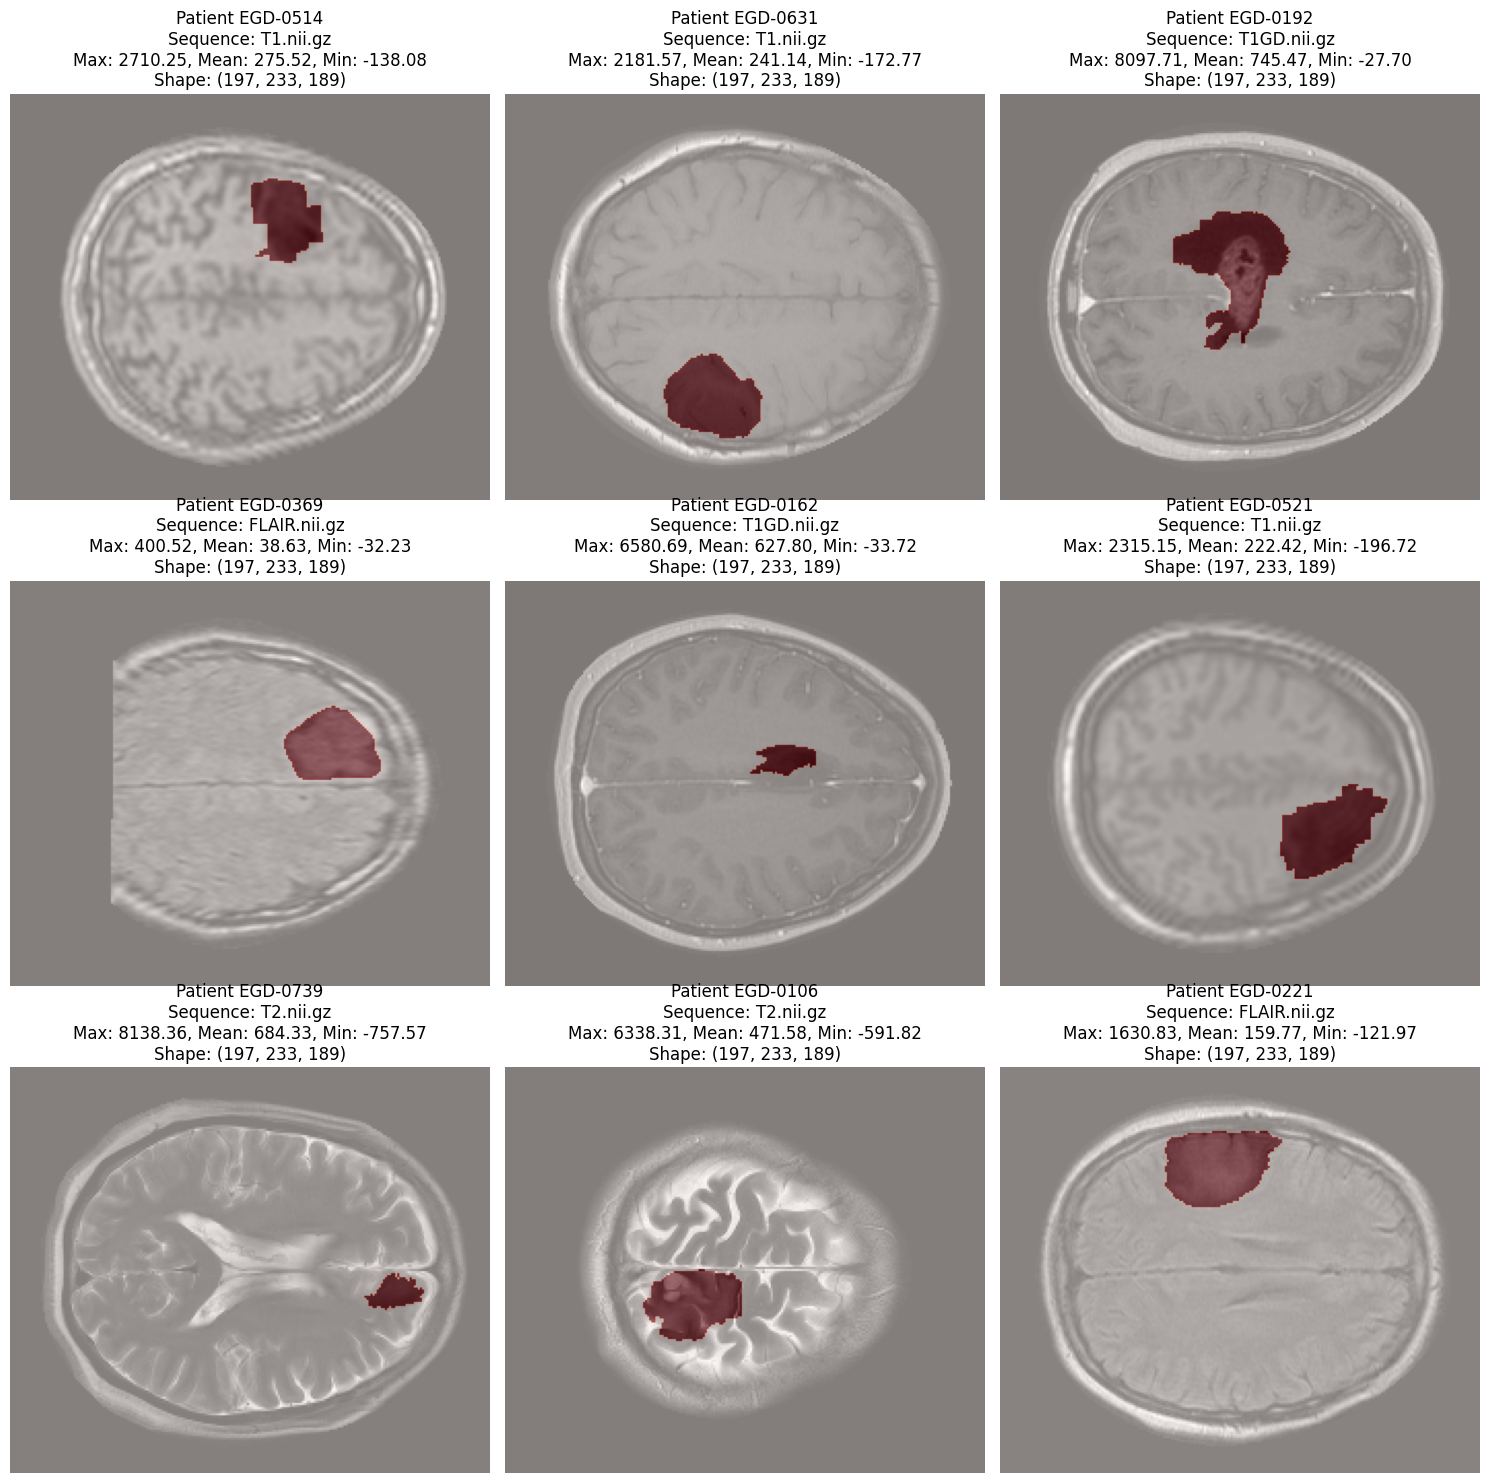

In [36]:
visualize_random_patients(all_patients)

Patients with errors: 0221, 0118, 0160, 0369